## Importing Librarires

In [93]:
# importing the required librearies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import numpy as np

## Dataset Generation

In [41]:
# Setting up basic constants
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
CHANNELS = 3

In [9]:
# Checking the data folder
dir_path = "data"
for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'data'.
There are 0 directories and 1000 images in 'data\Potato___Early_blight'.
There are 0 directories and 152 images in 'data\Potato___healthy'.
There are 0 directories and 1000 images in 'data\Potato___Late_blight'.


In [6]:
# Creating the dataset from the images present in given directories
dataset = tf.keras.preprocessing.image_dataset_from_directory("data", 
                                                              shuffle = True, 
                                                              image_size = IMG_SIZE, 
                                                              batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [10]:
# Getting the classnames
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
# Checking the length of dataset
# 68 as 2152 / 32 == 68
len(dataset)

68

In [13]:
# Checking a single image batch labels
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch)

(32, 256, 256, 3)
tf.Tensor([0 1 0 1 1 0 0 1 0 1 0 2 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 2 1 0 0], shape=(32,), dtype=int32)


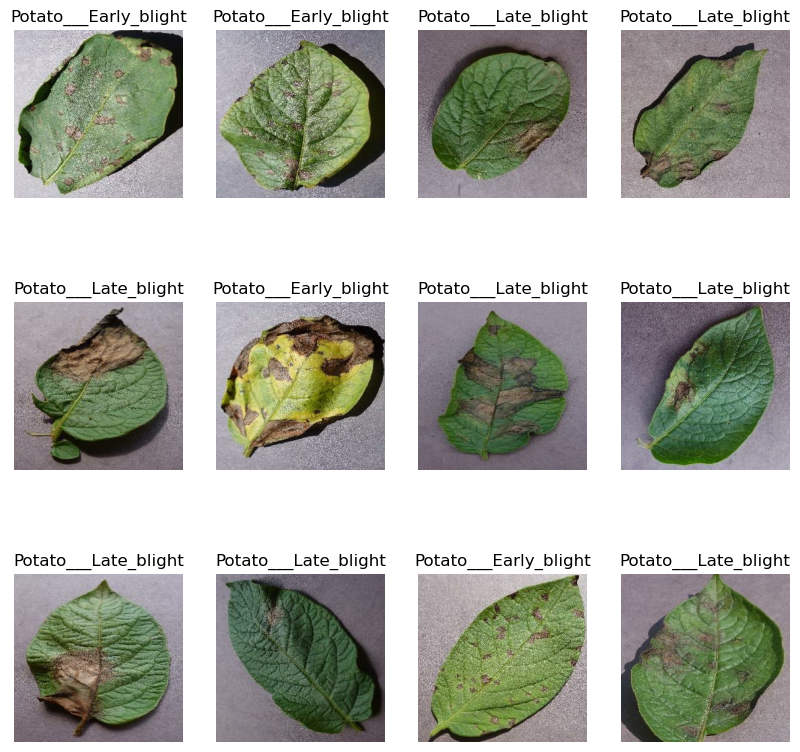

In [31]:
# Visualizing a single image with label
sample_batch = dataset.take(1)
plt.figure(figsize = (10,10))
for img, label in sample_batch:
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img[i].numpy().astype("uint32"))
        plt.title(class_names[label[i]])
        plt.axis("off")

## Splitting the Dataset

In [32]:
# 80% train; 10% validation, 10% test
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [33]:
# Creating the train_Dataset
train_data = dataset.take(54)
len(train_data)

54

In [34]:
# Creating temp dataset to further split into test and val
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [35]:
# Creating test and validation data
val_data = dataset.skip(54).take(6)
test_data = dataset.skip(60)
len(val_data), len(test_data)

(6, 8)

In [36]:
# Caching and prefetching data
train_data = train_data.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

## Data Augumentation

In [64]:
# Rescaling and Resizing
preprocessing = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE[0], IMG_SIZE[0]),
    layers.Rescaling(1.0/255),
])

In [65]:
# Augumenting Data
data_aug = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.2)
])


## Model Creation

In [66]:
# Using the Sequential API to create a CNN Model
input_shape = [BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], CHANNELS]
n_classes = 3

model = models.Sequential([
    preprocessing,
    data_aug,
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape = input_shape)

In [67]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_15 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_57 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_57 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_58 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

In [68]:
# Compilng the model
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = "adam",
              metrics = ["accuracy"])

In [69]:
!nvidia-smi

Thu Mar 30 00:11:28 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti    WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8                2W /  N/A|   4162MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [71]:
# Fitting the model
history = model.fit(train_data,
                    epochs = 50,
                    steps_per_epoch = len(train_data),
                    batch_size = BATCH_SIZE,
                    validation_data = val_data,
                    validation_steps = len(val_data))

Epoch 1/50
54/54 [==============================] - 16s 102ms/step - loss: 0.9127 - accuracy: 0.4630 - val_loss: 0.8518 - val_accuracy: 0.4792
Epoch 2/50
54/54 [==============================] - 4s 76ms/step - loss: 0.7556 - accuracy: 0.6458 - val_loss: 0.9256 - val_accuracy: 0.6042
Epoch 3/50
54/54 [==============================] - 4s 76ms/step - loss: 0.6057 - accuracy: 0.7517 - val_loss: 0.4990 - val_accuracy: 0.7917
Epoch 4/50
54/54 [==============================] - 4s 75ms/step - loss: 0.4575 - accuracy: 0.8154 - val_loss: 0.3285 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 4s 75ms/step - loss: 0.3932 - accuracy: 0.8328 - val_loss: 0.3465 - val_accuracy: 0.8906
Epoch 6/50
54/54 [==============================] - 4s 82ms/step - loss: 0.2466 - accuracy: 0.9010 - val_loss: 0.2536 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 4s 79ms/step - loss: 0.3268 - accuracy: 0.8779 - val_loss: 0.3900 - val_accuracy: 0.8438
Epoch 8/50


## Evaluating the Model

In [72]:
# Evaluating the model on test dataset
score = model.evaluate(test_data)
score

8/8 [==============================] - 2s 52ms/step - loss: 0.0339 - accuracy: 0.9914


[0.03389829769730568, 0.9913793206214905]

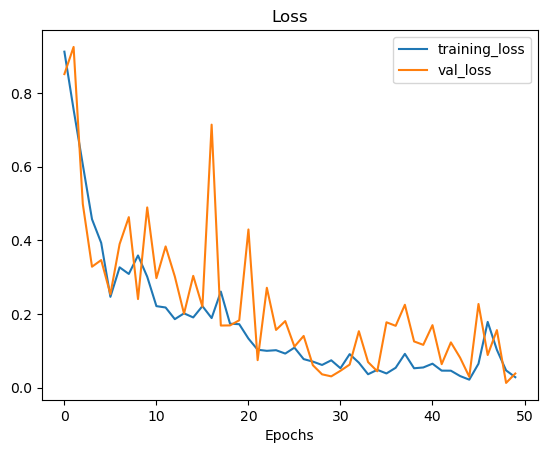

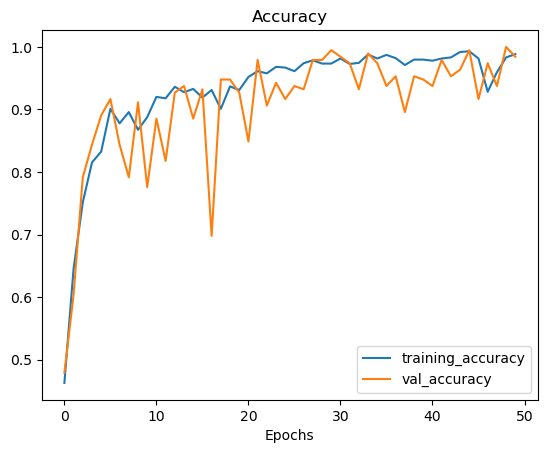

In [74]:
# Plotting the history

loss = history.history["loss"]
accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]
epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

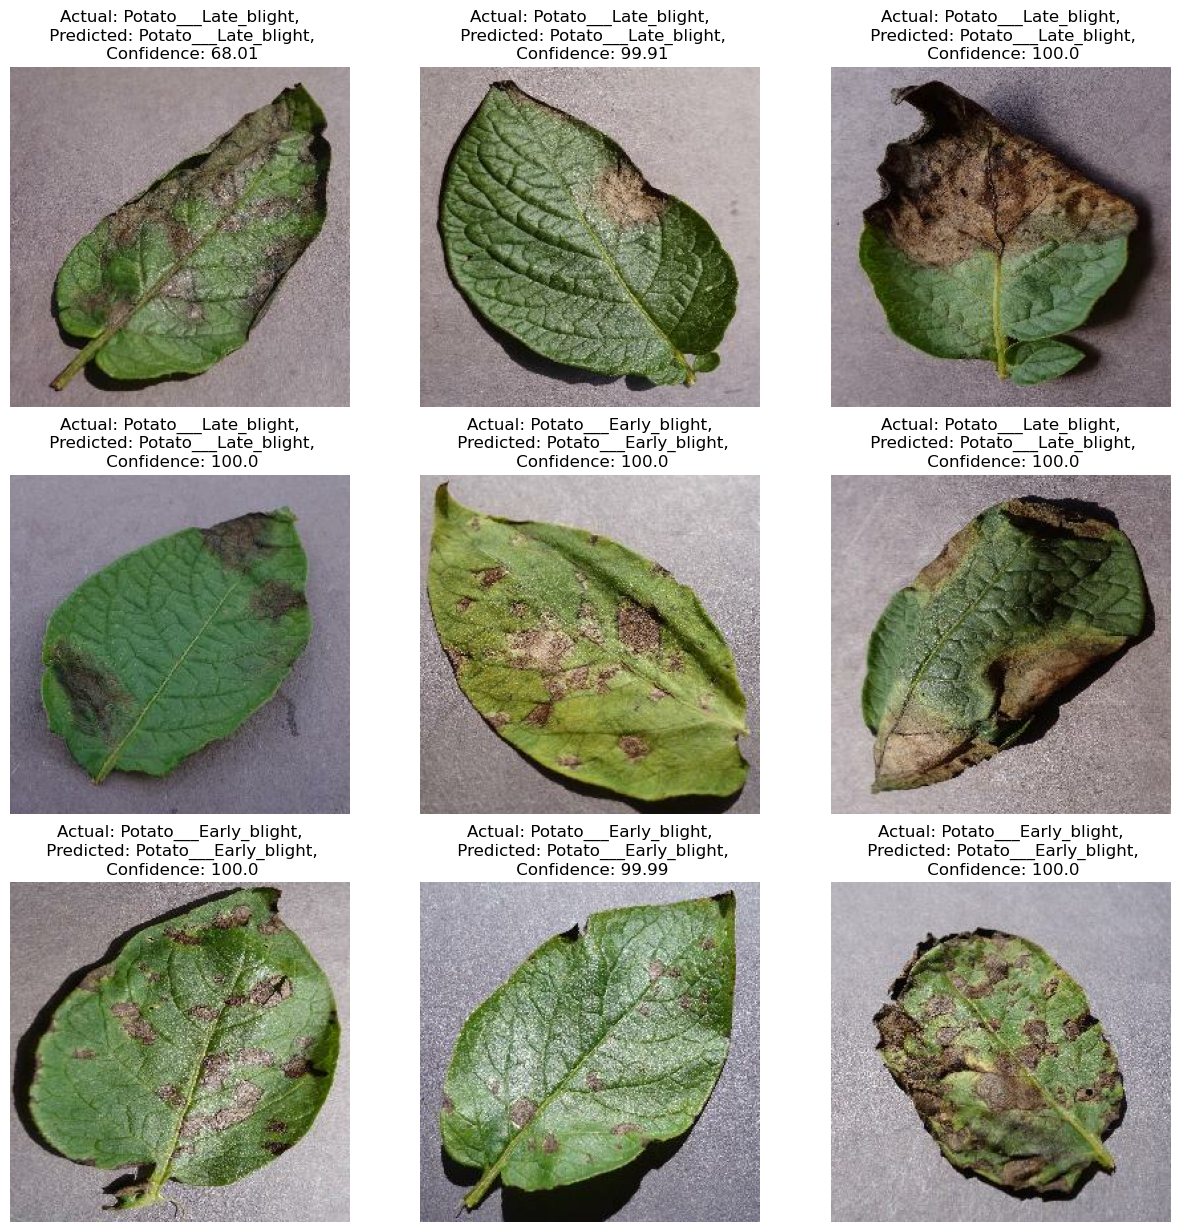

In [99]:
# Visualizing test results
sample_batch = test_data.take(1)
plt.figure(figsize = (15,15))
for img, label in sample_batch:
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img[i].numpy().astype("uint32"))
        pred_class = tf.argmax(model.predict(img)[i])
        confidence = round(100 * np.max(model.predict(img)[i]), 2)
        plt.title(f"Actual: {class_names[label[i]]},\n Predicted: {class_names[pred_class]},\n Confidence: {confidence}")
        plt.axis("off")

## Saving and Loading the Model

In [100]:
# Saving the model
model_version = 1
model.save(f"models/CNN{model_version}")

INFO:tensorflow:Assets written to: models/CNN1\assets


In [101]:
# Loading the model
loaded_model = tf.keras.models.load_model("models/CNN1")

In [102]:
loaded_model.evaluate(test_data)

8/8 [==============================] - 1s 41ms/step - loss: 0.0339 - accuracy: 0.9914


[0.03389829769730568, 0.9913793206214905]